In [1]:
# run multiple reps with no dinucleotide present

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyemma as py
import scipy
import sys, os

import math
import glob 

import MDAnalysis as mda
import nglview as ng
from nglview import NGLWidget
import mdtraj as md

from MDAnalysis import transformations

from sklearn.decomposition import PCA

from MDAnalysis.analysis import rms
from MDAnalysis.analysis import distances

/project/andrewferguson/Mike/conda_envs/abasic_env/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [2]:
# keep solvent

# file path
#mj_path = '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/'
mj_path = './gap_md/'

# list of different gap sizes
job_list = sorted(glob.glob(f'{mj_path}*gap*/'))

cmd_list = []
for job_dir in job_list:
    cmd_list.append('cd /project/andrewferguson/Mike/cut_analysis/gap_analysis')
    cmd_list.append(f'cd {job_dir}')
    #cmd_list.append('echo "DNA" | gmx trjconv -s md.tpr -f md.xtc -o md_nosolv.xtc -pbc whole')
    cmd_list.append('echo "system" | gmx trjconv -f md.xtc -s md.tpr -o md_withsolv.pdb -skip 100000')
        
for cmd in cmd_list:
    print(cmd)
print('\n\n')

cd /project/andrewferguson/Mike/cut_analysis/gap_analysis
cd ./gap_md/2000ns_310K_gap_AAAA_BSC1_DNA_/
echo "system" | gmx trjconv -f md.xtc -s md.tpr -o md_withsolv.pdb -skip 100000
cd /project/andrewferguson/Mike/cut_analysis/gap_analysis
cd ./gap_md/2000ns_310K_gap_AAAA_BSC1_DNA_rep1/
echo "system" | gmx trjconv -f md.xtc -s md.tpr -o md_withsolv.pdb -skip 100000
cd /project/andrewferguson/Mike/cut_analysis/gap_analysis
cd ./gap_md/2000ns_310K_gap_AAAA_BSC1_DNA_rep2/
echo "system" | gmx trjconv -f md.xtc -s md.tpr -o md_withsolv.pdb -skip 100000
cd /project/andrewferguson/Mike/cut_analysis/gap_analysis
cd ./gap_md/2000ns_310K_gap_AAAA_BSC1_DNA_rep3/
echo "system" | gmx trjconv -f md.xtc -s md.tpr -o md_withsolv.pdb -skip 100000
cd /project/andrewferguson/Mike/cut_analysis/gap_analysis
cd ./gap_md/2000ns_310K_gap_AAAA_BSC1_DNA_rep4/
echo "system" | gmx trjconv -f md.xtc -s md.tpr -o md_withsolv.pdb -skip 100000
cd /project/andrewferguson/Mike/cut_analysis/gap_analysis
cd ./gap_md/2000

In [3]:
## end to end distance for each gap
from pyemma.coordinates import featurizer

# set up shared axes for gap and ss-strand
cv_labels = ['End-to-end', 'RMSD (CTnC)', 'RMSD (Tn)']
color_list = ['blue', 'red', 'green']
nbins = 50
save_npys = True

## single strand first

# list of different gap sizes
single_names = ['CTTC', 'CTTTC', 'CTTTTC']
c5 = 30
c3_list = [92, 124, 156]

res_names = ['N3', 'O2', 'O4']
single_rdfs = []

# currently redundant as assumes more than one traj per category
for gap, c3, color in zip(single_names, c3_list, color_list):
    nbp = len(gap)
    resid_list = np.arange(1, nbp - 1)
    print(resid_list)
    
    pdb = glob.glob(f'{mj_path}*{gap}*/md_withsolv.pdb')[0]
    xtc = glob.glob(f'{mj_path}*{gap}*/md.xtc')[0]

    traj = md.load(xtc, top=pdb)
    top = traj.topology
    
    # find location of all oxygen pairs
    oxy_atoms = top.select('water and name O')
    
    T_rdfs = []
    for resid in resid_list:
    
        # find all relevant thymine atoms
        T_atoms = []
        for name in res_names:
            T_atoms += list(top.select(f'resid {resid} and name {name}'))

        pairs = []
        for T_idx in T_atoms:
            for oxy_idx in oxy_atoms:
                pairs.append((T_idx, oxy_idx))

        rdf = md.compute_rdf(traj, pairs=pairs)

        print(np.shape(pairs))
        print(np.shape(rdf))
        print('\n\n')
        
        T_rdfs.append(rdf)
    single_rdfs.append(T_rdfs)
        


[1 2]
(11769, 2)
(2, 200)



(11769, 2)
(2, 200)



[1 2 3]
(11739, 2)
(2, 200)



(11739, 2)
(2, 200)



(11739, 2)
(2, 200)



[1 2 3 4]
(11694, 2)
(2, 200)



(11694, 2)
(2, 200)



(11694, 2)
(2, 200)



(11694, 2)
(2, 200)





In [4]:
print(pairs[-3:])

[(145, 11872), (145, 11875), (145, 11878)]


In [5]:
## now to the gapped sequebces 

gap_list = ['gap_B', 'gap_AAA_B', 'gap_AAAA_B']
gap_names = ['AA', 'AAA', 'AAAA']

nbp_list = [14, 15, 16]
ngap_list = [2, 3, 4]
c5 = 566
c3_list = [630, 662, 694]

gap_rdfs = []

for gap, gap_name, nbp, ngap, c3, color in zip(
    gap_list, gap_names, nbp_list, ngap_list, c3_list, color_list):
    
    # select residues
    min_T = nbp + 6 - ngap
    max_T = min_T + ngap
    resid_list = np.arange(min_T, max_T)
    print(resid_list)
    
    pdb = glob.glob(f'{mj_path}*{gap}*/md_withsolv.pdb')[0]
    xtc_list = glob.glob(f'{mj_path}*{gap}*/md.xtc')[0]

    # load each traj object
    traj_list, feat_list = [], []
    
    traj = md.load(xtc_list, top=pdb) 
    top = traj.topology
    
    # find location of all oxygen pairs
    oxy_atoms = top.select('water and name O')
    
    T_rdfs = []
    for resid in resid_list:
    
        # find all relevant thymine atoms
        T_atoms = []
        for name in res_names:
            T_atoms += list(top.select(f'resid {resid} and name {name}'))

        pairs = []
        for T_idx in T_atoms:
            for oxy_idx in oxy_atoms:
                pairs.append((T_idx, oxy_idx))

        rdf = md.compute_rdf(traj, pairs=pairs)

        print(np.shape(pairs))
        print(np.shape(rdf))
        print('\n\n')
        
        T_rdfs.append(rdf)
    gap_rdfs.append(T_rdfs)
        
    

[18 19]
(34806, 2)
(2, 200)



(34806, 2)
(2, 200)



[18 19 20]
(39066, 2)
(2, 200)



(39066, 2)
(2, 200)



(39066, 2)
(2, 200)



[18 19 20 21]
(44658, 2)
(2, 200)



(44658, 2)
(2, 200)



(44658, 2)
(2, 200)



(44658, 2)
(2, 200)





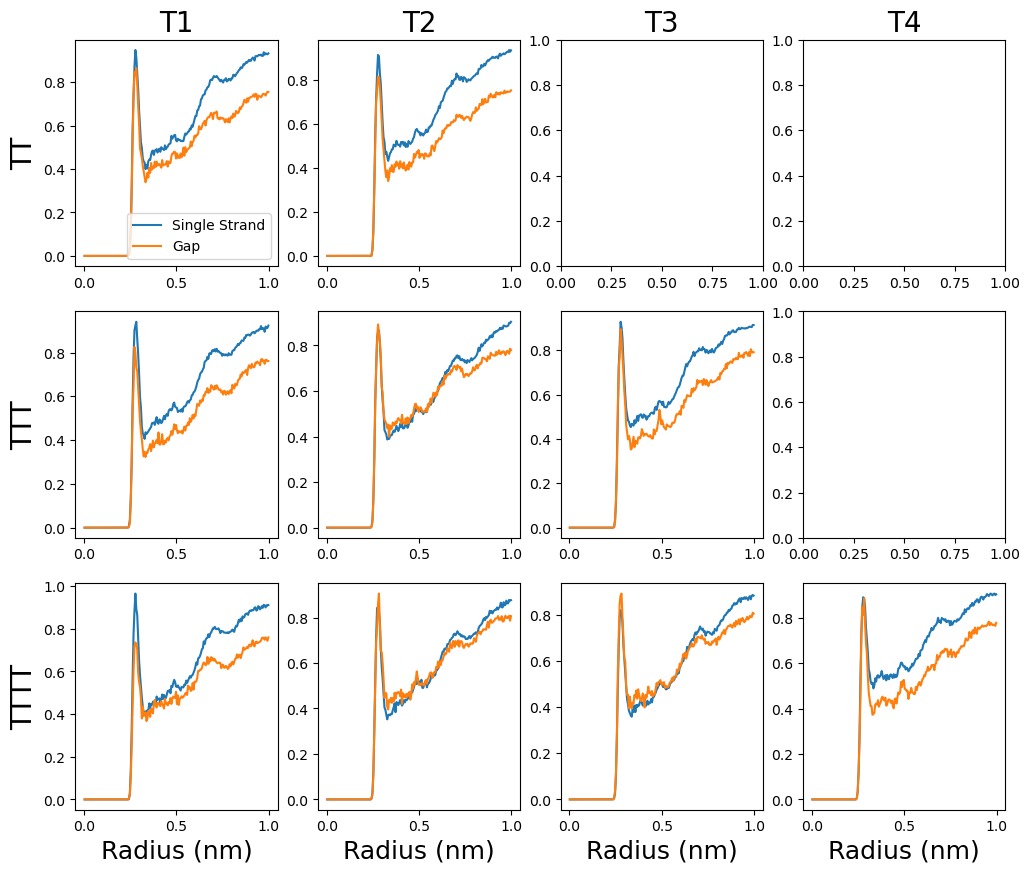

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(12, 10))

gap_names = ['TT', 'TTT', 'TTTT']

for g_name, g_rdf, s_name, s_rdf, ax_row in zip(
    gap_names, gap_rdfs, single_names, single_rdfs, axes):
    
    ax_row[0].set_ylabel(g_name, fontsize=20)
    
    for i, (s_T, g_T, ax) in enumerate(zip(s_rdf, g_rdf, ax_row)):
    
        ax.plot(s_T[0], s_T[1], label='Single Strand')
        ax.plot(g_T[0], g_T[1], label='Gap')
    
        if 'TTTT' in g_name:
            ax.set_xlabel('Radius (nm)', fontsize=18)
        
for i, ax in enumerate(axes[0]):
    ax.set_title(f'T{i+1}', fontsize=20)
            
axes[0, 0].legend()

# save as svg
plt.savefig('../svgs_221122/rdf_gaps.svg')


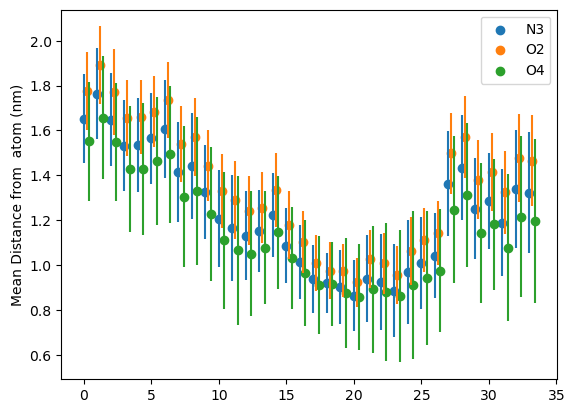

In [7]:
# distance between T and flank

## now to the gapped sequebces 

gap_list = ['gap_B']
gap_names = ['AA']

for i, name in enumerate(['N3', 'O2', 'O4']):

    for gap, gap_name in zip(gap_list, gap_names):

        # select residues
        G_resid = 6 - 1
        T_resid = 14 - 2 + 6

        pdb = glob.glob(f'{mj_path}*{gap}*/md_withsolv.pdb')[0]
        xtc_list = glob.glob(f'{mj_path}*{gap}*/md.xtc')[0]

        # load each traj object
        traj_list, feat_list = [], []

        traj = md.load(xtc_list, top=pdb) 
        top = traj.topology

        # find all relevant thymine atoms
        T_atoms = top.select(f'resid {T_resid} and name {name}')
        G_atoms = top.select(f'resid {G_resid}')

        pairs = []
        for T_idx in T_atoms:
            for G_idx in G_atoms:
                pairs.append((T_idx, G_idx))

        dists = md.compute_distances(traj, atom_pairs=pairs)

        plt.scatter(np.arange(len(dists[0]))+0.2*i, dists.mean(axis=0), 
                    label=name)
        
        plt.errorbar(np.arange(len(dists[0]))+0.2*i, dists.mean(axis=0), 
                     yerr=dists.std(axis=0), linestyle='')
        
        plt.ylabel(f'Mean Distance from  atom (nm)')
plt.legend()

# save as svg
plt.savefig('../svgs_221122/nearest_atom_gaps.svg')

In [ ]:
# tag nearest solvent molecules to look at residency times

# isolate phase space based on

In [ ]:
# try fixing whole and periodic as follows: https://gromacs.bioexcel.eu/t/correcting-periodicity-in-gmx/165
# make molecules whole first then remove jumps


echo "system" | gmx trjconv -f md.xtc -s md.tpr -o md_whole.xtc -pbc mol
echo "system" | gmx trjconv -f md_whole.xtc -s md.tpr -o md_whole_nojump.xtc -pbc nojump



In [18]:
# isolate phase space based on superposed structures

# def get_solvent(xtc_solv, pdb_solv, n_dna, n_total, resid_list)
# return water_idxs_list # (index of solvent atoms to use at each frame)

xtc_solv = './gap_md/2000ns_310K_gap_BSC1_DNA_rep1/md_whole.xtc'
pdb_solv = './gap_md/2000ns_310K_gap_BSC1_DNA_rep1/md_withsolv.pdb'

n_dna = 817
n_total = 35898
n_frames = 100

traj = md.load(xtc_solv, top=pdb_solv)[:n_frames]
traj = traj.superpose(traj, frame=0, atom_indices=np.arange(n_dna), ref_atom_indices=np.arange(n_dna))
print(traj.xyz.shape)

# compare relative OW -- N3 distancec compared to backbone dists (needs to be shared with ssDNA)

resid_list = [18, 19] #[18, 19]  # for AA gap only

top = traj.topology
oxy_atoms = top.select('water and name O')
    
# find all relevant thymine atoms
N3_atoms = []
for resid in resid_list:
    N3_atoms += list(top.select(f'resid {resid} and name N3'))
    
# find all relevant phosphate atoms
P_atoms = []
for resid in resid_list:
    P_atoms += list(top.select(f'resid {resid} and name P'))

N3_dists_list = []
P_dists_list = []

for oxy_idx in oxy_atoms:
        
    N3_dists = md.compute_distances(traj, [(oxy_idx, N3_idx) for N3_idx in N3_atoms])  #[0] index for first frame only
    P_dists = md.compute_distances(traj, [(oxy_idx, P_idx) for P_idx in P_atoms])      #[0]
    
    # save distance to nearest of each
    N3_min = np.min(N3_dists, axis=1) #, axis=1)
    P_min = np.min(P_dists, axis=1)   #, axis=1)
    
    N3_dists_list.append(N3_min)
    P_dists_list.append(P_min)
    
N3_dists_list = np.array(N3_dists_list)
P_dists_list = np.array(P_dists_list)

print(N3_dists_list.shape, P_dists_list.shape)

cutoff = 1.5 # nm

water_idxs_list = []
for i in range(n_frames):
    
    oxy_viz_idxs = np.where((N3_dists_list[:, i] < P_dists_list[:, i]) & (N3_dists_list[:, i] < cutoff) )[0]

    # add hydrogens to slice list
    water_viz_idxs = []
    for idx in oxy_viz_idxs:
        water_viz_idxs += [n_dna + 3*idx + i for i in range(3)]

    water_viz_idxs = np.array(water_viz_idxs) # frame_idx
    print(np.shape(water_viz_idxs), min(water_viz_idxs), max(water_viz_idxs))
    
    water_idxs_list.append(water_viz_idxs)
    


(100, 35898, 3)
(11602, 100) (11602, 100)
(690,) 1516 35529
(747,) 1165 35049
(720,) 1594 35562
(777,) 1048 35568
(726,) 820 35421
(834,) 952 35547
(717,) 841 35016
(750,) 898 35439
(747,) 1072 35169
(738,) 841 35553
(753,) 841 35481
(741,) 841 35586
(726,) 856 35445
(801,) 922 35481
(822,) 868 35250
(1029,) 817 35472
(669,) 949 35427
(996,) 889 35328
(1338,) 925 35232
(1299,) 895 35574
(1242,) 868 35601
(897,) 1033 35544
(1104,) 922 35556
(1500,) 1057 35574
(1239,) 925 35385
(603,) 925 35475
(882,) 835 35583
(687,) 826 35592
(891,) 835 35490
(1050,) 874 35391
(1053,) 823 35316
(1170,) 841 35559
(858,) 916 35541
(792,) 928 35487
(771,) 949 35613
(864,) 1135 35529
(804,) 886 35511
(927,) 883 35616
(1038,) 919 35508
(990,) 910 35451
(771,) 1144 35451
(717,) 874 35256
(756,) 928 35559
(1494,) 913 35610
(1467,) 952 35568
(1500,) 913 35541
(1401,) 919 35541
(1038,) 949 35535
(1080,) 1117 35439
(990,) 970 35523
(1074,) 925 35580
(843,) 838 35442
(1041,) 922 35613
(864,) 859 35613
(966,) 874 

In [17]:
# add traj components one at a time
view = NGLWidget()          
view.add_trajectory(traj.atom_slice(np.arange(n_dna)) )
view.add_trajectory(traj.atom_slice(water_idxs_list[-1]) )

#view.add_representation('cartoon')
c_list = ['blue', 'red']
op_list = [1.0, 0.2]

for v, c, op in zip(view, c_list, op_list):
    v.clear_representations()
    v.add_representation('licorice', color=c, opacity=op) #selection='not hydrogen'
view

NGLWidget(max_frame=9)

In [ ]:
# check residency times of water in these regions